# Problem Statement

Efficient Market Hypothesis postulates that stocks always trade at their fair value on exchanges, making it impossible for investors to purchase undervalued stocks or sell stocks for inflated prices. Random Walk Theory suggests that changes in stock prices have the same distribution and are independent of each other. Both of these two theories suggest that it's  impossible to beat the market with readily available public information. This project aims to use Machine Learning techniques including Facebook Prophet, ARIMA forecasting as well as Neural Network to make below predictions:

1. Price prediction
2. Price forecast
3. Buy/Sell signals

Bitcoin has been around for 10 years or so, and we're approaching a period of a major euphoria (at time of writing, Q2 2020) and hype about its underlying technology as well as solutions. There are several other alternative coins out there, but this project only aims to do predictions on Bitcoin prices using a combination of on-chain metrics and technical indicators to do so. There have been several different Bitcoin pricing models out there (e.g. Stock-to-Flow, Melcalfe's Law), but this project aims to apply a supervised learning Machine Learning approach to make predictions on next day's price directional prediction. 

A typical Bitcoin strategy is to buy and hold for the long term. This is the baseline that we want to beat - we want to have a machine learning model that is able to predict buy/sell signals on a daily basis and in turn beating the former returns over the same time period. Our model beats the fair odds by 4% and generates 70% more returns over the same time frame as compared to a typical buy-and-hold strategy.

# Executive Summary

This project is broken up to two different notebooks:

    1. Data Mining & EDA
        - On-Chain Features
        - Technical Analysis Features
        
Here we gather our data and explore them accordingly. Features here may or may not be used in the final model. You'll find several charts across history on Bitcoin prices here, including those from on-chain metrics like unique active addresses, hash rate and transaction count. We also take a look at Simple Moving Averages and see how SMA1458 plays a role in historical prices. We also feature new columns here to use for our final model.

    2. Model
        - Facebook Prophet
        - ARIMA
        - LSTM Price Prediction (Lookback=1)
        - LSTM Price Prediction (Lookback=7)
        - Random Forest Classifier
        - LSTM (Buy/sell signal)
        - LSTM (Buy/sell signal) with Leaky Relu
         
This notebook will contain all the modelling aspect of this project, including Facebook's Prophet, ARIMA forecasting and LSTM modelling. Our model aims to tackle and predict below targets, with focus being more on buy/sell signals. We'll also explore using LSTM to make price predictions which is actually a very common practice in the internet, of which there are concerns that I'll be raising as well.
  
1. Price prediction
2. Price forecast
3. Buy/Sell signals


## Data Dictionary

| Feature             | Description |
|---------------------|-------------|
| 'Close',            |     The fixed closing price of the asset as of 00:00 UTC the following day (i.e., midnight UTC of the current day) denominated in USD.         |
| 'Close_Diff1',      |     Difference of order 1 of close price        |
| 'LogClose',         |    Logarithmic of close price         |
| 'LogClose_Diff1',   |     Difference of order 1 of log close price         |
| 'Returns',          |     Percentage returns from previous day close price        |
| 'Target',           |     Next day's buy/sell signal        |
| 'Target_shifted',   |     Next day's buy/sell signal shifted up 1 time interval        |
| 'Year',             |     Calendar year        |
| 'HashRate',         |     Hash rate is the computation speed at which computations are being completed across all miners in the network        |
| 'LogHashRate',      |     Logarithmic of hash rate        |
| 'AdrActCnt',        |      The sum count of unique addresses that were active in the network (either as a recipient or originator of a ledger change) that interval.        |
| 'LogAdrActCnt',     |      Log of unique addresses       |
| 'TxCnt',            |        The sum count of transactions that interval.     |
| 'LogTxCnt',         |       Log of transaction count      |
| 'Goog_Trend',       |      Score on Google Trends       |
| 'Goog_Trend_Diff1', |      Difference of order 1 of Google Trends       |
| 'RSI'               |      Relative Strength Index       |

# Imports

Import libraries and set default settings

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import numpy as np
import talib as ta

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels as sm
from statsmodels.tsa.arima_model import ARIMA

from pytrends.request import TrendReq
from pytrends import dailydata

plt.style.use('tableau-colorblind10')
sns.set_style("darkgrid")
sns.set_context("talk")

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

Pull Google Trends data

In [2]:
# btc_goog = dailydata.get_daily_data('bitcoin', 2009, 1, 2021, 3, geo='')
# btc_goog.drop(columns=['bitcoin_monthly', 'isPartial', 'scale', 'bitcoin'], inplace=True)
# btc_goog.to_csv('../data/btc_goog.csv', index_label='Date')

Import BTC on-chain dataset (https://coinmetrics.io/community-network-data/)

In [3]:
btc = pd.read_csv('../data/btc_onchain.csv')
btc_goog = pd.read_csv('../data/btc_goog.csv')

Change `Date` to datetime format, feature `Year` and `Month` columns

In [4]:
btc['Date'] = pd.to_datetime(btc['date'])
btc['Year'] = btc['Date'].dt.year
btc['Month'] = btc['Date'].dt.month

Set `Date` as index

In [5]:
btc.set_index('Date', inplace=True)
btc.sort_index(inplace=True)

In [6]:
btc_goog['Date'] = pd.to_datetime(btc_goog['Date'])
btc_goog.set_index('Date', inplace=True)
btc_goog.sort_index(inplace=True)

In [7]:
btc = btc.join(btc_goog, how='left')

In [8]:
btc.rename(columns={'bitcoin_unscaled': 'Goog_Trend'}, inplace=True)

# Bitcoin On-chain Metrics

Check data types

In [9]:
btc.dtypes

date                       object
AdrActCnt                 float64
AssetEODCompletionTime    float64
BlkCnt                    float64
BlkSizeByte               float64
BlkSizeMeanByte           float64
CapMVRVCur                float64
CapMrktCurUSD             float64
CapRealUSD                float64
DiffMean                  float64
FeeMeanNtv                float64
FeeMeanUSD                float64
FeeMedNtv                 float64
FeeMedUSD                 float64
FeeTotNtv                 float64
FeeTotUSD                 float64
HashRate                  float64
IssContNtv                float64
IssContPctAnn             float64
IssContUSD                float64
IssTotNtv                 float64
IssTotUSD                 float64
NVTAdj                    float64
NVTAdj90                  float64
PriceBTC                    int64
PriceUSD                  float64
ROI1yr                    float64
ROI30d                    float64
SplyCur                   float64
SplyExpFut10yr

Check standard descriptions for dataset

In [10]:
btc.describe()

,AdrActCnt,AssetEODCompletionTime,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,FeeMeanUSD,FeeMedNtv,FeeMedUSD,FeeTotNtv,FeeTotUSD,HashRate,IssContNtv,IssContPctAnn,IssContUSD,IssTotNtv,IssTotUSD,NVTAdj,NVTAdj90,PriceBTC,PriceUSD,ROI1yr,ROI30d,SplyCur,SplyExpFut10yrCMBI,SplyFF,TxCnt,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d,Year,Month,Goog_Trend
count,4.483000e+03,4.483000e+03,4483.000000,4.483000e+03,4.477000e+03,3922.000000,3.922000e+03,4.483000e+03,4.477000e+03,4225.000000,3922.000000,4225.000000,3922.000000,4483.000000,3.922000e+03,4.477000e+03,4477.000000,4477.000000,3.922000e+03,4477.000000,3.922000e+03,4.223000e+03,3833.000000,4484.0,3923.000000,3558.000000,3893.000000,4.483000e+03,4.477000e+03,4.483000e+03,4483.000000,4.483000e+03,4.483000e+03,3.922000e+03,4225.000000,3922.000000,4.225000e+03,3.922000e+03,4.483000e+03,3.922000e+03,3743.000000,3893.000000,3863.000000,4484.000000,4484.000000,4106.000000
mean,3.648221e+05,1.614357e+09,151.456168,7.562404e+07,5.074830e+05,2.072175,7.422908e+10,3.270644e+10,3.070059e+12,0.000904,1.582875,0.000408,0.830767,54.478171,4.774669e+05,2.238619e+07,4172.675620,78.946674,6.168512e+06,4172.675620,6.168512e+06,3.467260e+04,63.497971,1.0,4174.403612,791.326891,20.225829,1.217344e+07,1.943544e+07,1.058770e+07,141157.076957,3.445798e+05,2.478348e+05,1.125273e+09,92.559260,4706.791631,5.332417e+01,4.201381e+01,1.035319e+06,3.187841e+09,0.048304,0.043848,0.045762,2014.652765,6.427297,58.651242
std,3.550083e+05,2.332511e+05,34.863417,6.844086e+07,4.637088e+05,2.971956,1.552496e+11,5.475677e+10,5.767401e+12,0.007641,4.540864,0.005767,2.523944,99.321111,1.472195e+06,4.203225e+07,2861.810407,834.948740,9.190318e+06,2861.810407,9.190318e+06,1.549004e+06,33.272432,0.0,8430.239704,2336.080110,65.050760,5.645276e+06,1.014174e+06,4.372467e+06,127820.353640,3.136177e+05,1.749008e+05,2.181175e+09,668.964886,6654.725031,6.321021e+02,5.609347e+01,1.894152e+06,5.834451e+09,0.021081,0.029234,0.026395,3.547591,3.471091,25.563089
min,0.000000e+00,1.614335e+09,0.000000,0.000000e+00,2.150000e+02,0.386829,1.776705e+05,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.988411e-07,200.000000,1.169460,3.070000e+02,200.000000,3.070000e+02,3.717399e+00,11.810125,1.0,0.050541,-83.730494,-61.668266,0.000000e+00,1.707025e+07,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,4.647065e+02,0.010000,0.762873,1.000000e-08,8.203471e-08,0.000000e+00,5.874592e+02,0.020298,0.007481,0.010406,2009.000000,1.000000,0.000000
25%,1.881450e+04,1.614336e+09,138.000000,3.505538e+06,2.332627e+04,1.261066,7.647299e+08,4.362272e+07,1.583178e+06,0.000141,0.033384,0.000017,0.021654,9.079868,2.361020e+03,1.145994e+01,1887.500000,4.083325,3.110184e+05,1887.500000,3.110184e+05,3.837790e+01,41.349958,1.0,69.064612,22.707528,-9.338708,8.218867e+06,1.875429e+07,8.216255e+06,7612.500000,1.798350e+04,1.318012e+05,1.751767e+07,1.341251,552.198973,1.105211e-02,3.741887e+00,3.642119e+05,6.116484e+07,0.032594,0.025111,0.027875,2012.000000,3.000000,44.000000
50%,2.476460e+05,1.614337e+09,151.000000,5.470911e+07,3.756871e+05,1.702003,7.471600e+09,4.204159e+09,4.668438e+10,0.000241,0.121166,0.000100,0.061372,23.458165,1.447033e+04,3.229962e+05,3675.000000,9.931633,1.695374e+06,3675.000000,1.695374e+06,5.815095e+01,54.407268,1.0,573.263192,150.946913,5.215237,1.386839e+07,1.978366e+07,1.263928e+07,96199.000000,2.644960e+05,2.348947e+05,1.708114e+08,3.380388,1836.822138,2.680072e-02,1.622938e+01,6.670714e+05,6.753281e+08,0.042205,0.035667,0.038558,2015.000000,6.000000,63.000000
75%,6.606265e+05,1.614337e+09,165.000000,1.401612e+08,9.576345e+05,2.380780,1.122490e+11,7.738720e+10,3.462542e+12,0.000663,0.903953,0.000224,0.350676,53.815762,2.413188e+05,2.556413e+07,5850.000000,31.842911,9.952140e+06,5850.000000,9.952140e+06,8.379053e+01,78.912695,1.0,6497.856280,

Take a look at correlations to Bitcoin price in descending order, sorted for top 20.

In [11]:
abs(btc.corr()['PriceUSD']).sort_values(ascending=False).head(30)

PriceUSD                  1.000000
CapMrktCurUSD             0.999567
TxTfrValAdjUSD            0.936071
IssContUSD                0.928368
IssTotUSD                 0.928368
CapRealUSD                0.924623
TxTfrValUSD               0.837653
TxTfrValMeanUSD           0.797082
HashRate                  0.782732
DiffMean                  0.779701
TxTfrValMedUSD            0.720620
FeeMeanUSD                0.709528
FeeTotUSD                 0.688411
AdrActCnt                 0.677222
FeeMedUSD                 0.650389
Year                      0.623848
TxTfrCnt                  0.601427
AssetEODCompletionTime    0.597908
BlkSizeMeanByte           0.597559
BlkSizeByte               0.596589
TxCnt                     0.523817
SplyExpFut10yrCMBI        0.498482
SplyCur                   0.491897
IssContNtv                0.451649
IssTotNtv                 0.451649
SplyFF                    0.403806
IssContPctAnn             0.310947
NVTAdj90                  0.296294
FeeTotNtv           

There are a number of features above that aren't useful to use as they are intuitively directly correlated with Bitcoin price (example market capitalization, value of new issuance). We'll select some below to take a deeper look in the later section of this notebook.

Check for null values in `PriceUSD`

In [12]:
btc['PriceUSD'].isnull().sum()

561

In [13]:
btc[['PriceUSD']][btc['PriceUSD'].isnull()]

,PriceUSD
Date,
2009-01-03,NaN
2009-01-04,NaN
2009-01-05,NaN
2009-01-06,NaN
2009-01-07,NaN
...,...
2010-07-13,NaN
2010-07-14,NaN
2010-07-15,NaN


Looks like null values range from 2009 to 2010, we'll drop out null values

In [14]:
btc = btc.dropna(axis=0, subset=['PriceUSD'])

Check for other null values

In [15]:
btc.isnull().sum().sort_values(ascending=False)

ROI1yr                    365
VtyDayRet180d             180
NVTAdj90                   90
VtyDayRet60d               60
ROI30d                     30
VtyDayRet30d               30
Goog_Trend                 13
TxTfrValNtv                 1
TxTfrValMedUSD              1
IssContNtv                  1
HashRate                    1
FeeTotUSD                   1
FeeTotNtv                   1
FeeMedUSD                   1
FeeMedNtv                   1
FeeMeanUSD                  1
FeeMeanNtv                  1
DiffMean                    1
CapRealUSD                  1
CapMrktCurUSD               1
CapMVRVCur                  1
BlkSizeMeanByte             1
BlkSizeByte                 1
BlkCnt                      1
AssetEODCompletionTime      1
AdrActCnt                   1
IssContPctAnn               1
IssContUSD                  1
IssTotNtv                   1
SplyFF                      1
TxTfrValMedNtv              1
TxTfrValMeanUSD             1
TxTfrValMeanNtv             1
TxTfrValAd

Drop nulls

In [16]:
btc = btc.drop(columns=[
    'ROI1yr',
    'VtyDayRet180d',
    'NVTAdj90',
    'VtyDayRet60d',
    'VtyDayRet30d',
    'ROI30d'
])

In [17]:
btc['Goog_Trend_Diff1'] = btc['Goog_Trend'].diff()

Rename `PriceUSD` column to `Close`

In [18]:
btc.rename(columns={'PriceUSD': 'Close'}, inplace=True)

# On-Chain Features

We take a deeper look on some of the features available from the Bitcoin on-chain data. We can see that there are quite a number of features available, but not all will be feasible to be used. I have shortlisted some to be used as part of our model.

## `Close`

Plot the `Close` price over the years to look at the trend

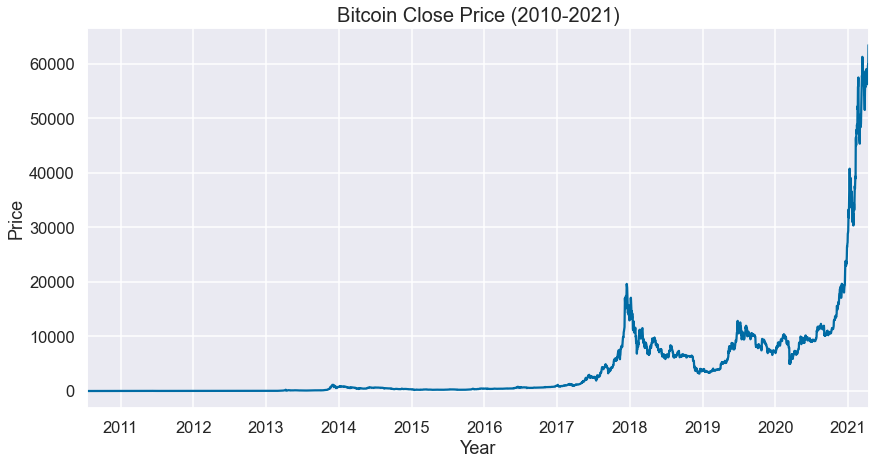

In [19]:
plt.figure(figsize=(14,7))
btc['Close'].plot()
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Bitcoin Close Price (2010-2021)', size=20)
plt.savefig('../images/close1.png', transparent=True)

We observe that there's distinct volatility happening from 2017 onwards. However, the volatilities prior to this period could be masked due to the exponential growth in price. We take a look at different windows of time periods to investigate further

1. 2017-2021
2. 2010-2016
3. 2010-2013

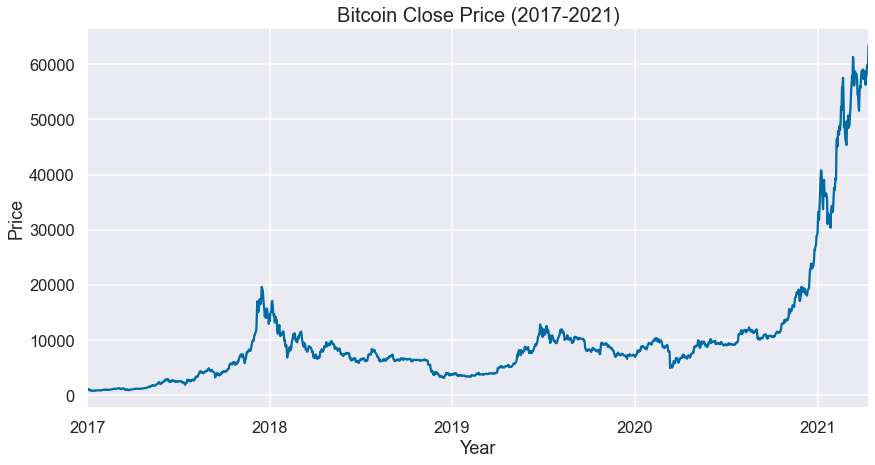

In [20]:
btc2 = btc[btc['Year'] > 2016]
plt.figure(figsize=(14,7))
btc2['Close'].plot()
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Bitcoin Close Price (2017-2021)', size=20)
plt.savefig('../images/close2.png', transparent=True)

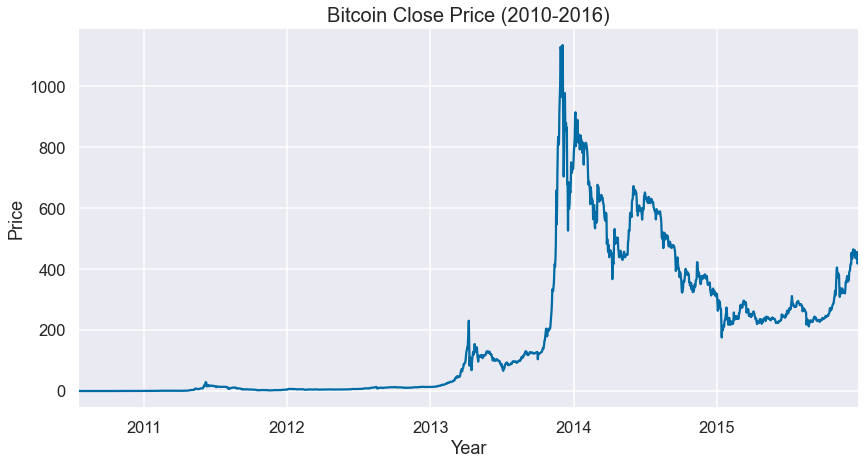

In [21]:
btc3 = btc[btc['Year'] < 2016]
plt.figure(figsize=(14,7))
btc3['Close'].plot()
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Bitcoin Close Price (2010-2016)', size=20)
plt.savefig('../images/close3.png', transparent=True)

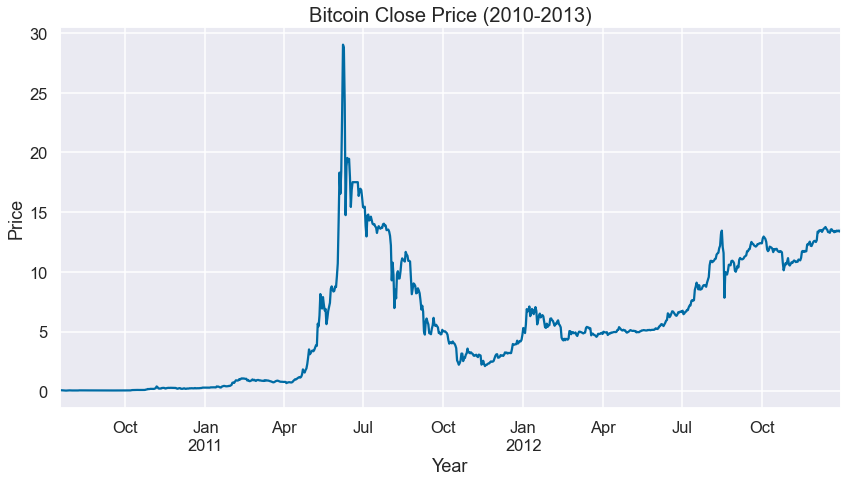

In [22]:
btc4 = btc[btc['Year'] < 2013]
plt.figure(figsize=(14,7))
btc4['Close'].plot()
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Bitcoin Close Price (2010-2013)', size=20);
plt.savefig('../images/close4.png', transparent=True)

We can see that on the full timeframe, the volatilities that happen in the earlier years have been masked due to the exponential increment in absolute price of Bitcoin. It does not make sense to use `Close` as the main parameter for our models. We'll explore taking the logarithmic `Close` to see how it trends over the years.
  
We can check for stationarity using the Augmented Dickey-Fuller test.

Define a function to print out test statistic and p-value from Augmented Dickey-Fuller test.

In [23]:
def dfuller(df):
    print('Test Statistic: ' + str(adfuller(df)[0]))
    print('p-value: ' + str(adfuller(df)[1]))

Augmented Dickey-Fuller test on `Close`

In [24]:
dfuller(btc['Close'])

Test Statistic: 8.24511967665339
p-value: 1.0


For large p-values, we have don't have enough evidence to reject the null hypothesis that our time series is not stationary.

## `LogClose`

Per above, we want to take the Logarithmic `Close` to see if we can see any smoothing effect on the `Close` price.

Create `LogClose` column

In [25]:
btc['LogClose'] = np.log(btc['Close'])

Plot `LogClose` over time

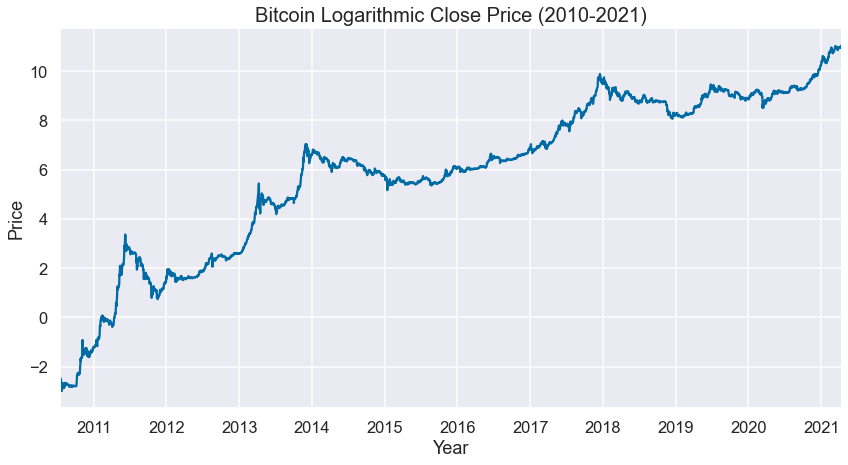

In [26]:
plt.figure(figsize=(14,7))
btc['LogClose'].plot()
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Bitcoin Logarithmic Close Price (2010-2021)', size=20)
plt.savefig('../images/logclose.png', transparent=True)

Run the Augmented Dickey-Fuller test on `LogClose`

In [27]:
dfuller(btc['LogClose'])

Test Statistic: -2.2779011660297024
p-value: 0.17919436172487185


Again, we observe that p-value is not small enough to reject our null hypothesis and that we still have a non-stationary dataset. We'll explore using returns or differences `Close` price instead.

## `Returns`

Create a `Returns` column based on previous day's `Close` price

In [28]:
btc['Returns'] = btc['Close'].pct_change()

In [29]:
btc.head()

,date,AdrActCnt,AssetEODCompletionTime,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,FeeMeanUSD,FeeMedNtv,FeeMedUSD,FeeTotNtv,FeeTotUSD,HashRate,IssContNtv,IssContPctAnn,IssContUSD,IssTotNtv,IssTotUSD,NVTAdj,PriceBTC,Close,SplyCur,SplyExpFut10yrCMBI,SplyFF,TxCnt,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,Year,Month,Goog_Trend,Goog_Trend_Diff1,LogClose,Returns
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-07-18,2010-07-18,860.0,1.614335e+09,172.0,136889.0,795.866279,146.038332,295959.152000,2026.585401,181.543289,0.003185,0.000273,0.0,0.0,0.79,0.067814,0.001552,8600.0,91.043564,738.224000,8600.0,738.224000,200.680421,1,0.085840,3447800.0,17931962.5,3447800.0,248.0,396.0,17180.55,1474.778412,48.783737,4.187596,1.850,0.158804,19318.36,1658.288022,2010,7,17.0,NaN,-2.455270,NaN
2010-07-19,2010-07-19,929.0,1.614335e+09,174.0,139254.0,800.310345,62.565130,279285.200000,4463.911468,181.543289,0.000150,0.000012,0.0,0.0,0.05,0.004040,0.001570,8700.0,91.870389,702.960000,8700.0,702.960000,85.889156,1,0.080800,3456500.0,17934137.5,3456500.0,334.0,512.0,40243.73,3251.693384,86.951152,7.025653,2.625,0.212100,44518.99,3597.134392,2010,7,13.0,-4.0,-2.515778,-0.058714
2010-07-20,2010-07-20,936.0,1.614335e+09,181.0,197425.0,1090.745856,45.106630,259000.404990,5741.958660,181.543289,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.001633,9050.0,95.316761,676.358346,9050.0,676.358346,215.744281,1,0.074736,3465550.0,17936400.0,3465550.0,423.0,738.0,16063.23,1200.497201,42.528835,3.178423,1.375,0.102762,31386.28,2345.676511,2010,7,13.0,0.0,-2.593797,-0.075053
2010-07-21,2010-07-21,784.0,1.614335e+09,207.0,124991.0,603.821256,38.357560,275266.471297,7176.328942,181.543289,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.001868,10350.0,108.684082,819.646128,10350.0,819.646128,166.836660,1,0.079193,3475900.0,17938987.5,3475900.0,247.0,377.0,20834.15,1649.915979,71.822334,5.687816,18.500,1.465068,27077.02,2144.306726,2010,7,0.0,-13.0,-2.535869,0.059639
2010-07-22,2010-07-22,594.0,1.614335e+09,176.0,100750.0,572.443182,25.132348,203749.573975,8107.064743,181.543289,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.001588,8800.0,92.174362,514.533891,8800.0,514.533891,105.440311,1,0.058470,3484700.0,17941187.5,3484700.0,221.0,344.0,33049.03,1932.368865,112.714622,6.590397,1.010,0.059054,38773.83,2267.096549,2010,7,39.0,39.0,-2.839246,-0.261679


Since first row has no differencing reference, it returns null value for `Returns`. We'll drop this row.

In [30]:
btc.dropna(inplace=True)

Run Augmented Dickey-Fuller test

In [31]:
dfuller(btc['Returns'])

Test Statistic: -10.023572473949676
p-value: 1.6544644899427573e-17


p-value is very small and we're able to reject the hypothesis and accept the null hypothesis that our data is now stationary.
  
Let's plot the `Returns` over time.

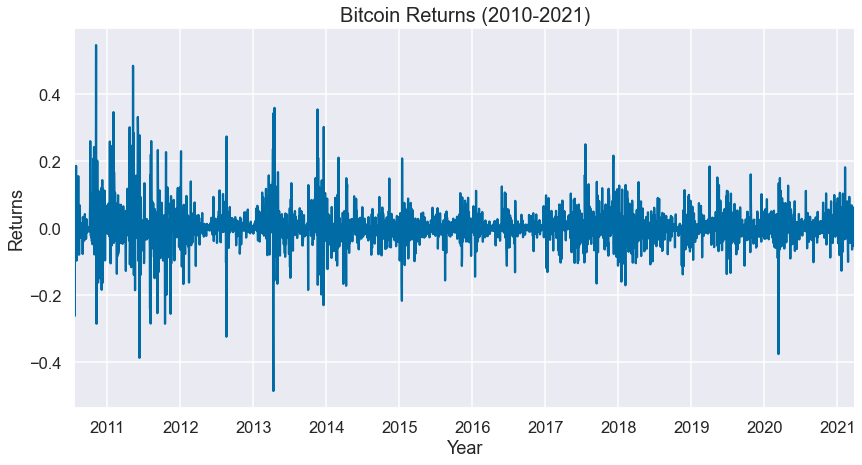

In [32]:
btc['Returns'].plot(figsize=(14,7))
plt.xlabel('Year')
plt.ylabel('Returns')
plt.title('Bitcoin Returns (2010-2021)', size=20);

We can observe that dataset has a mean of 0 which is a good sign of stationarity.

## `Close_Diff1` and `LogClose_Diff1`

As an alternative, we also take the difference on each day's `Close` price as well. This will also be useful for ARIMA time-series.
  
Create `Close_Diff1` column

In [33]:
btc['Close_Diff1'] = btc['Close'].diff()

Create `LogClose_Diff1` column

In [34]:
btc['LogClose_Diff1'] = btc['LogClose'].diff()

Plot `Close_Diff1` over time

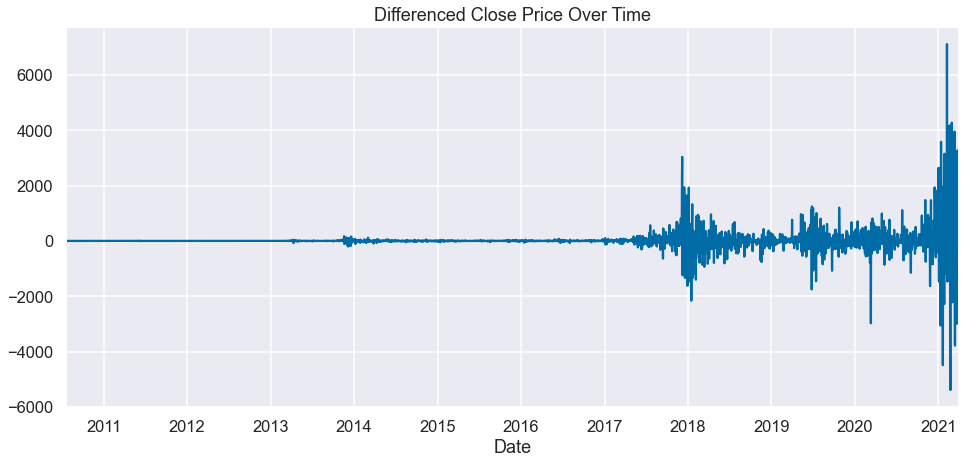

In [35]:
btc['Close_Diff1'].plot(figsize=(16,7))
plt.title('Differenced Close Price Over Time')
plt.savefig('../images/diff1.png', transparent=True)

If we compare above plot to the previous plot for `Returns` over time, it's interesting to observe that the differenced plot exhibits bigger changes from 2017. This is expected due to the exponential growth over time of Bitcoin, especially from 2017 as observed in the `Close` price chart. As price increases, the absolute change increases as well. We also observe a mean 0, meaning the dataset is stationary.

Plot `LogClose_Diff1` over time

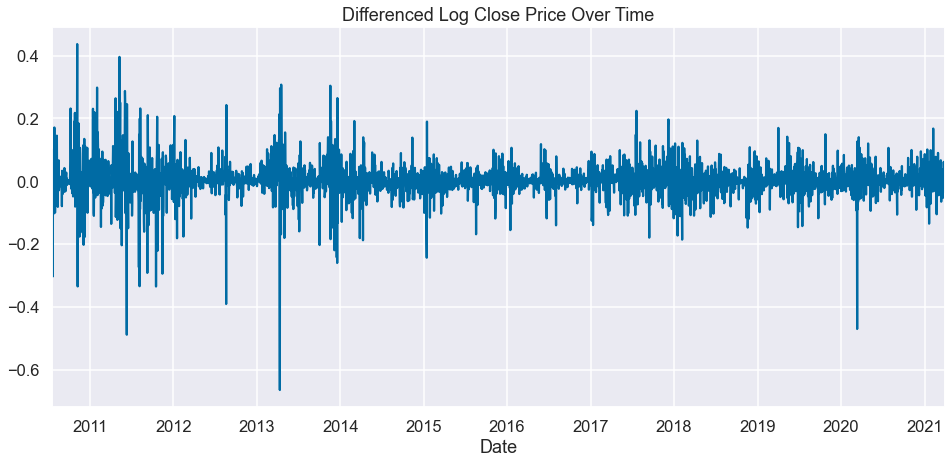

In [36]:
btc['LogClose_Diff1'].plot(figsize=(16,7))
plt.title('Differenced Log Close Price Over Time')
plt.savefig('../images/logdiff1.png', transparent=True)

We can see that the `LogClose_Diff1` plot is fairly similar to `Returns` plot, but seem to assign a more balanced distribution across the time period. The fluctuations for `Returns` is significantly larger in the early years. Using the `LogClose_Diff1` seem to smoothen this a little more.

Run Augmented Dickey-Fuller test

In [37]:
btc.dropna(inplace=True)

dfuller(btc['Close_Diff1'])

Test Statistic: -10.17526462760734
p-value: 6.9191214356475376e-18


In [38]:
dfuller(btc['LogClose_Diff1'])

Test Statistic: -10.475528259070334
p-value: 1.2519503510855612e-18


Both p-values are very small and we're able to reject the hypothesis and accept the null hypothesis that both data points are stationary.

## `Target`

We also want to create buy/sell targets. If next day's return is positive, it means that we want to make a buy order today. We use this intuition to create our `Target` column. We also create a `Target_shifted` column as we also want to feed tomorrow's price target into our non Neural Network classifier at a later stage. 
  
*If you're confused now, Keras' TimeSeriesGenerator will default to taking next day's target as output whereas non Neural Network classifiers like RandomForestClassifier will not do so.*

In [39]:
btc['Target_shifted'] = np.where(btc['Returns'].shift(-1) > 0, 1, 0)
btc['Target'] = np.where(btc['Returns'] > 0, 1, 0)

## `AdrActCnt`

`AdrActCnt` is the count of unique addresses that were active in the network in the previous day. Theoretically speaking, we can expect that if there's higher counts of active unique addresses, it implicitly means higher volume and more holders of Bitcoin.

Create a function to easily plot two features

In [40]:
def compare_plot(df1, df2, label1, label2, plot_title):
    fig, ax = plt.subplots(1, 1, figsize=(14,7))
    ax.plot(df1, 'salmon', label=label1)
    ax2 = ax.twinx()
    ax2.plot(df2, 'lightslategrey', label=label2)
    plt.draw()
    plt.title(plot_title, size=20)
    ax.legend()
    ax2.legend(loc=1);

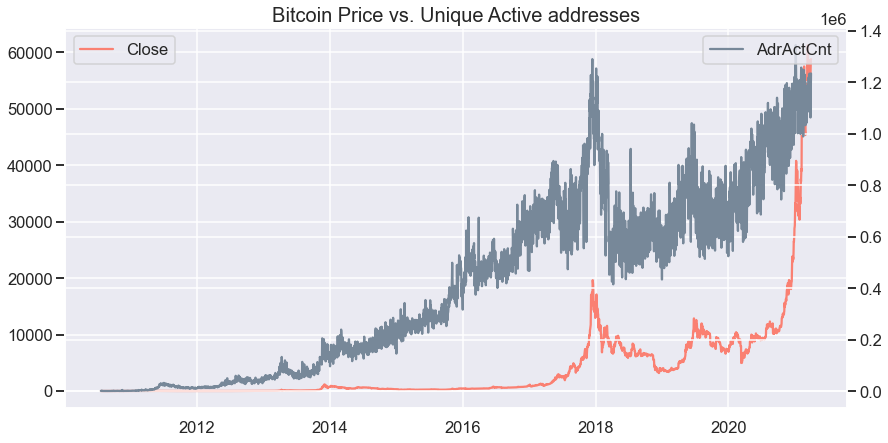

In [41]:
compare_plot(btc['Close'], 
             btc['AdrActCnt'], 
             'Close', 
             'AdrActCnt', 
             'Bitcoin Price vs. Unique Active addresses')

Above we can see a positive relationship. The 2018 spike follows closely as well. 
  
Couple of observations above:
1. Spike in 2018 Bitcoin price and unique addresses moved in tendem with each other
2. Growth in unique addresses through 2010-2016 did not reflect the same growth in Bitcoin price
  
Let's also take the Logarithmic `AdrActCnt` as well.

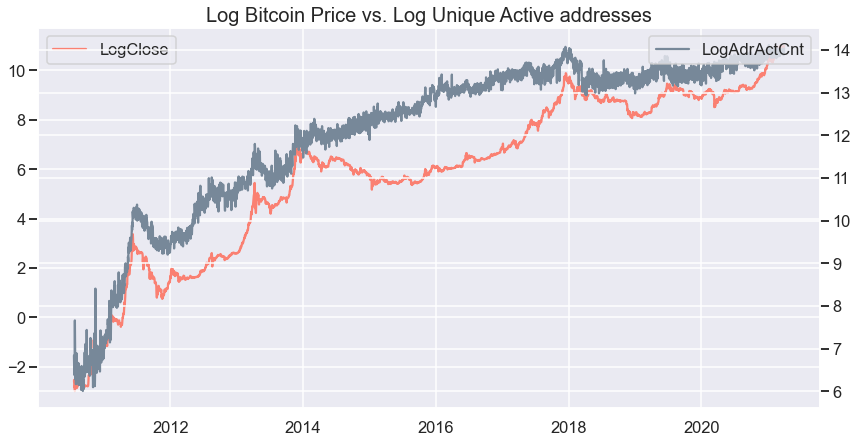

In [42]:
btc['LogAdrActCnt'] = np.log(btc['AdrActCnt'])

compare_plot(btc['LogClose'], 
             btc['LogAdrActCnt'], 
             'LogClose', 
             'LogAdrActCnt', 
             'Log Bitcoin Price vs. Log Unique Active addresses')
plt.savefig('../images/logadd.png', transparent=True)

We see that their relationship is very similar (in the general sense). This is interesting as it explains the network effect that Bitcoin has that's likely contributing to the exponential growth in price.

## `Hashrate`

Hash rate is the speed at which miners are able to perform proof-of-work calculations (to mine a Bitcoin, miners have to solve a proof-of-work problem). The higher the hash rate, the more blocks are being mined which increases the chance an individual miner has to solve the block reward puzzle and receive newly mined Bitcoin. Typically, a high hash rate is an indication of a healthy bitcoin mining environment. It reflects in some sense that miners are willing to improve their mining infrastructure to be more effective in mining, hence an implicit sign that they are anticipating a rise of Bitcoin's price.

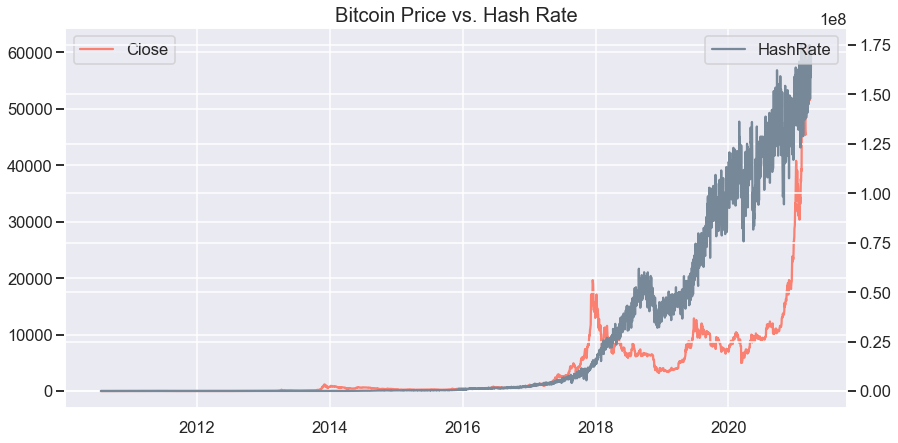

In [43]:
compare_plot(btc['Close'], 
             btc['HashRate'], 
             'Close', 
             'HashRate', 
             'Bitcoin Price vs. Hash Rate')

We plot `LogHashRate` and `LogClose` to observe their relationship

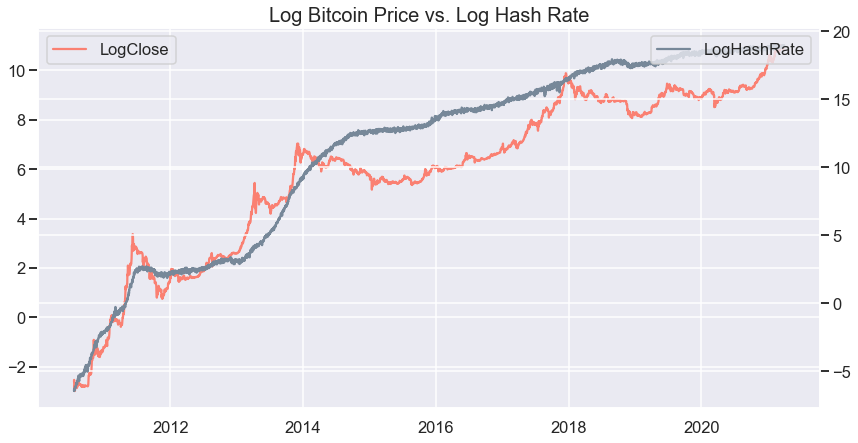

In [44]:
btc['LogHashRate'] = np.log(btc['HashRate'])

compare_plot(btc['LogClose'], 
             btc['LogHashRate'], 
             'LogClose', 
             'LogHashRate', 
             'Log Bitcoin Price vs. Log Hash Rate')
plt.savefig('../images/loghash.png', transparent=True)

Again, we see very similar trends between the logarithmics of `Close` and `HashRate`.

## `TxCnt`

Transaction count is the sum count of transactions that interval.

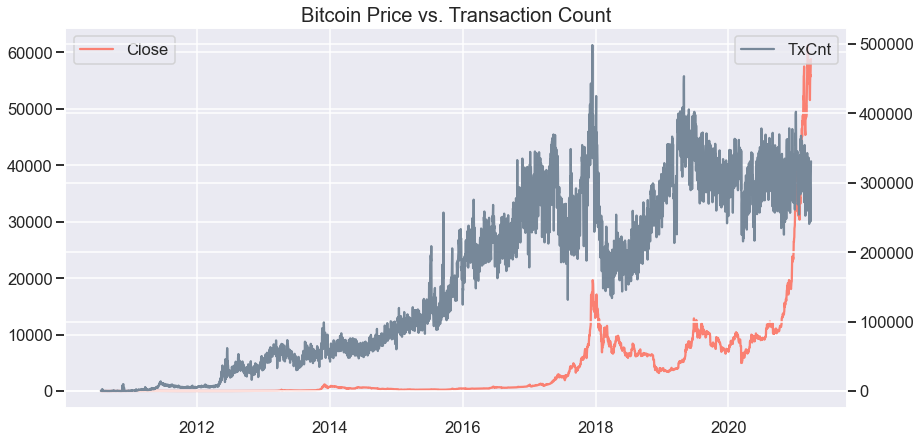

In [45]:
compare_plot(btc['Close'], 
             btc['TxCnt'], 
             'Close', 
             'TxCnt', 
             'Bitcoin Price vs. Transaction Count')

We plot `LogTxCnt` and `LogClose` to observe their relationship

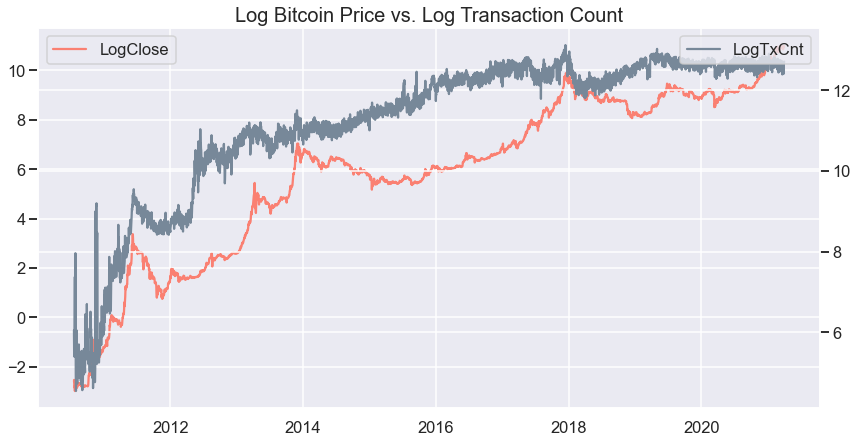

In [46]:
btc['LogTxCnt'] = np.log(btc['TxCnt'])

compare_plot(btc['LogClose'], 
             btc['LogTxCnt'], 
             'LogClose', 
             'LogTxCnt', 
             'Log Bitcoin Price vs. Log Transaction Count')
plt.savefig('../images/logtx.png', transparent=True)

## Google Trends

We also had data from Google Trends available on a daily basis. We plot out the trends over time.

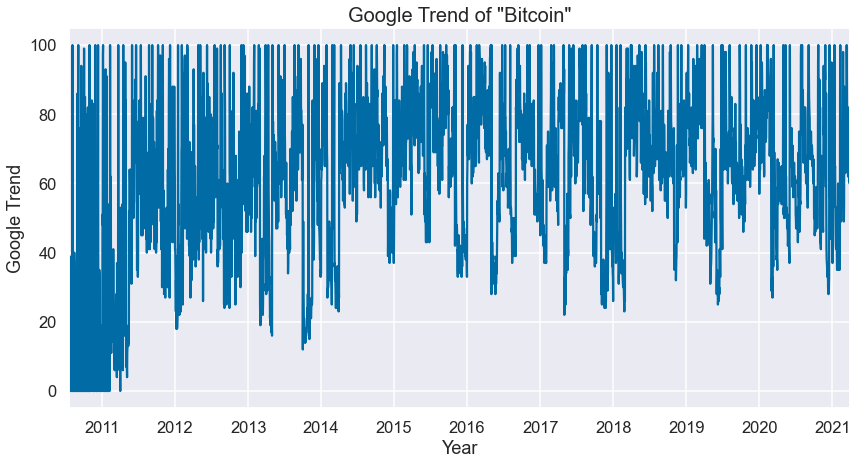

In [56]:
plt.figure(figsize=(14,7))
btc['Goog_Trend'].plot()
plt.xlabel('Year')
plt.ylabel('Google Trend')
plt.title('Google Trend of "Bitcoin"', size=20)
plt.savefig('../images/logclose.png', transparent=True)

# Technical Analysis Features

## SMA1458

A simple moving average (SMA) calculates the average of a selected range of prices, usually closing prices, by the number of periods in that range. Here for Bitcoin we calculate SMA for period of 4 years (1458 days). SMA1458 indicator is fairly known in Bitcoin space as it has proven to be a very good support for Bitcoin price. Bitcoin has almost never dipped past this support line before.

In [ ]:
btc['SMA1458'] = ta.SMA(btc['Close'], 1458)
btc[['Close', 'SMA1458']].plot(figsize=(14,7))
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Bitcoin Close Price with SMA1458', size=20)
plt.savefig('../images/sma1458.png', transparent=True)

In [ ]:
btc2 = btc[btc['Year'] > 2016]
btc2[['Close', 'SMA1458']].plot(figsize=(14,7))
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Bitcoin Close Price with SMA1458', size=20)
plt.savefig('../images/sma1458_2.png', transparent=True)

We can see that the price briefly dipped below the SMA1458 during first half of 2020 but rose back above again. We're now in a zone where we're very far above the SMA1458 and may signify some risk of market correction in time.

## Relative Strength Index (RSI)

Relative Strenth Index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. The RSI ranges from 0 to 100 and trends up or down based on previous average gain/loss.

In [ ]:
btc['RSI'] = ta.RSI(btc['Close'],14)
btc['RSI'].plot(figsize=(16,7))
plt.title('Relative Strength Index', size=20)
plt.ylabel('RSI')
plt.xlabel('Year')
plt.savefig('../images/rsi.png', transparent=True)

The plot is not very meaningful as it's more relevant for day to day trading. This should be useful for our model to understand whether Bitcoin has been overbaught and oversold at the current interval.

# Export

In [ ]:
btc.columns

In [ ]:
cols_to_keep = [
    'Close',
    'Close_Diff1',
    'LogClose',
    'LogClose_Diff1',
    'Returns',
    'Target',
    'Target_shifted',
    'Year', 
    'HashRate', 
    'LogHashRate',
    'AdrActCnt',
    'LogAdrActCnt',
    'TxCnt',
    'LogTxCnt',
    'Goog_Trend',
    'Goog_Trend_Diff1',
    'RSI'
]

In [ ]:
btc = btc[cols_to_keep]
btc.dropna(inplace=True)

In [ ]:
btc.to_csv('../data/btc.csv')